In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, recall_score
import matplotlib.pyplot as plt
import pickle

## Load training and validation data with data augmentation and test data

In [ ]:
# Load the .npz file containing preprocessed data
loaded_data = np.load("PATH1.npz")  # Replace with actual file path

# Access individual datasets
x_train_val_image = loaded_data["x_train_val_image"]  # 3D image data for training/validation
x_train_val_table = loaded_data["x_train_val_table"]  # Tabular clinical data
y_train_val = loaded_data["y_train_val"]  # Labels

# Check the original dataset shape
print("Before shuffle:")
print(x_train_val_image.shape, x_train_val_table.shape, y_train_val.shape)

# Ensure all arrays have the same first dimension
assert x_train_val_image.shape[0] == x_train_val_table.shape[0] == y_train_val.shape[0], "Shapes mismatch!"

# Shuffle the dataset while maintaining correspondence
indices = np.arange(x_train_val_image.shape[0])  # Create an index array
np.random.shuffle(indices)  # Shuffle indices

# Apply shuffled indices to all arrays
x_train_val_image = x_train_val_image[indices]
x_train_val_table = x_train_val_table[indices]
y_train_val = y_train_val[indices]

# Print dataset shape after shuffling
print("After shuffle:")
print(x_train_val_image.shape, x_train_val_table.shape, y_train_val.shape)

# Load test dataset
x_test_image = loaded_data["x_test_image"]
x_test_table = loaded_data["x_test_table"]
y_test = loaded_data["y_test"]

# Print test dataset shape
print(x_test_image.shape, x_test_table.shape, y_test.shape)

Before shuffle:
(687, 262, 352, 80, 1) (687, 1) (687,)
After shuffle:
(687, 262, 352, 80, 1) (687, 1) (687,)


## Load training and validation data without data augmentation (rawTrainVal set)

In [ ]:
# Load the .npz file
loaded_data = np.load("PATH2.npz")  # Replace with actual file path

# Access individual datasets
x_train_val_image_raw = loaded_data["x_train_val_image"]  # Non-augmented images
x_train_val_table_raw = loaded_data["x_train_val_table"]  # Non-augmented clinical data
y_train_val_raw = loaded_data["y_train_val"]  # Labels for non-augmented data

# Verify dataset shapes
print(x_train_val_image_raw.shape, x_train_val_table_raw.shape, y_train_val_raw.shape)

(412, 262, 352, 80, 1) (412, 1) (412,)


#  **Training and validation**

In [ ]:
# Number of cross-validation folds
num_folds = 5

# Define folder for saving model checkpoints
checkpoint_folder = "PATH3"  # Replace with actual directory path

## Define tabular model for postoperative days (non-imaging branch)

In [ ]:
fold = 0  # Initialize fold index

def model_tabular(number_of_items=x_train_val_table.shape[1], fold=fold):
    """
    Define a simple neural network for tabular clinical data.
    """
    # Input layer
    inputs = keras.Input((number_of_items,), name=f"tabular_input_fold_{fold}")

    # First dense block
    t = layers.Dense(units=512, kernel_initializer="he_normal", name=f"tabular_dense_1_fold_{fold}")(inputs)
    t = layers.BatchNormalization(name=f"tabular_batch_norm_1_fold_{fold}")(t)
    t = layers.Activation("relu", name=f"tabular_activation_1_fold_{fold}")(t)
    t = layers.Dropout(0.3, name=f"tabular_dropout_1_fold_{fold}")(t)

    # Second dense block
    t = layers.Dense(units=256, kernel_initializer="he_normal", name=f"tabular_dense_2_fold_{fold}")(t)
    t = layers.BatchNormalization(name=f"tabular_batch_norm_2_fold_{fold}")(t)
    t = layers.Activation("relu", name=f"tabular_activation_2_fold_{fold}")(t)
    t = layers.Dropout(0.3, name=f"tabular_dropout_2_fold_{fold}")(t)

    # Output layer
    outputs = layers.Dense(units=256, activation="relu", kernel_initializer="he_normal", name=f"tabular_output_dense_fold_{fold}")(t)

    # Create and return the model
    model = keras.Model(inputs, outputs, name=f"TabularModel_Fold_{fold}")
    return model


tf.random.set_seed(42)
tabular_model = model_tabular()
tabular_model.summary()

## Define 3D CNN model for preoperative CT images (imaging branch)

In [ ]:
def model_image(height=x_train_val_image.shape[1], width=x_train_val_image.shape[2], number_of_slices=x_train_val_image.shape[3], fold=fold):
    """
    Define a 3D CNN model for medical image analysis.
    """
    inputs = keras.Input((height, width, number_of_slices, 1), name=f"image_input_fold_{fold}")  # Input layer

    # Convolutional layers
    l = layers.Conv3D(filters=64, kernel_size=3, kernel_initializer="he_normal", name=f"conv3d_1_fold_{fold}")(inputs)
    l = layers.BatchNormalization(name=f"batch_norm_1_fold_{fold}")(l)
    l = layers.Activation("relu", name=f"activation_1_fold_{fold}")(l)
    l = layers.MaxPool3D(pool_size=2, name=f"maxpool_1_fold_{fold}")(l)

    l = layers.Conv3D(filters=64, kernel_size=3, kernel_initializer="he_normal", name=f"conv3d_2_fold_{fold}")(l)
    l = layers.BatchNormalization(name=f"batch_norm_2_fold_{fold}")(l)
    l = layers.Activation("relu", name=f"activation_2_fold_{fold}")(l)
    l = layers.MaxPool3D(pool_size=2, name=f"maxpool_2_fold_{fold}")(l)

    l = layers.Conv3D(filters=128, kernel_size=3, kernel_initializer="he_normal", name=f"conv3d_3_fold_{fold}")(l)
    l = layers.BatchNormalization(name=f"batch_norm_3_fold_{fold}")(l)
    l = layers.Activation("relu", name=f"activation_3_fold_{fold}")(l)
    l = layers.MaxPool3D(pool_size=2, name=f"maxpool_3_fold_{fold}")(l)

    l = layers.Conv3D(filters=256, kernel_size=3, kernel_initializer="he_normal", name=f"conv3d_4_fold_{fold}")(l)
    l = layers.BatchNormalization(name=f"batch_norm_4_fold_{fold}")(l)
    l = layers.Activation("relu", name=f"activation_4_fold_{fold}")(l)
    l = layers.MaxPool3D(pool_size=2, name=f"maxpool_4_fold_{fold}")(l)

    l = layers.GlobalAveragePooling3D(name=f"global_avg_pool_fold_{fold}")(l)
    l = layers.Dense(units=512, activation="relu", kernel_initializer="he_normal", name=f"dense_1_fold_{fold}")(l)
    l = layers.Dropout(0.3, name=f"dropout_1_fold_{fold}")(l)

    outputs = layers.Dense(units=1, activation="sigmoid", name=f"output_dense_fold_{fold}")(l)

    model = keras.Model(inputs, outputs, name=f"ImageModel_Fold_{fold}")
    return model

tf.random.set_seed(42)
image_model = model_image()
image_model.summary()

NameError: name 'x_train_val_image' is not defined

## Combine tabular and image models into a multimodal network

In [ ]:
def multimodal_model(tabular_model, image_model, fold):
    """
    Merge tabular and image models into a single multimodal network.
    """
    # Get the inputs and outputs from the tabular and image models
    tabular_inputs = tabular_model.input
    tabular_outputs = tabular_model.output

    image_inputs = image_model.input
    image_outputs = image_model.output

    # Combine the outputs from the two models
    combined = tf.keras.layers.Concatenate(name=f"combine_tabular_image_fold_{fold}")([tabular_outputs, image_outputs])

    # Add additional dense layers for the combined model
    x = tf.keras.layers.Dense(units=256, kernel_initializer="he_normal", name=f"dense_256_fold_{fold}")(combined)
    x = tf.keras.layers.BatchNormalization(name=f"batch_norm_fold_{fold}")(x)
    x = tf.keras.layers.Activation("relu", name=f"activation_relu_fold_{fold}")(x)
    x = tf.keras.layers.Dropout(0.3, name=f"dropout_30_fold_{fold}")(x)

    # Final output layer (for binary classification)
    outputs = tf.keras.layers.Dense(units=1, activation="sigmoid", name=f"output_fold_{fold}")(x)

    # Define the final model
    model = tf.keras.Model(inputs=[tabular_inputs, image_inputs], outputs=outputs, name=f"MultimodalModel_Fold_{fold}")
    return model

tf.random.set_seed(42)
model = multimodal_model(tabular_model, image_model, fold)
model.summary()

Model: "MultimodalModel_Fold_0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input_fold_0        │ (None, 262, 352, 80,   │              0 │ -                      │
│ (InputLayer)              │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1_fold_0 (Conv3D)  │ (None, 260, 350, 78,   │          1,792 │ image_input_fold_0[0]… │
│                           │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_norm_1_fold_0       │ (None, 260, 350, 78,   │            256 │ conv3d_1_fold_0[0][0]  │
│ (BatchNormalization)      │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1_fold_0       │ (None, 260, 350, 78,   │              0 │ batch_norm_1_fold_0[0… │
│ (Activation)              │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool_1_fold_0          │ (None, 130, 175, 39,   │              0 │ activation_1_fold_0[0… │
│ (MaxPooling3D)            │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2_fold_0 (Conv3D)  │ (None, 128, 173, 37,   │        110,656 │ maxpool_1_fold_0[0][0] │
│                           │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_norm_2_fold_0       │ (None, 128, 173, 37,   │            256 │ conv3d_2_fold_0[0][0]  │
│ (BatchNormalization)      │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2_fold_0       │ (None, 128, 173, 37,   │              0 │ batch_norm_2_fold_0[0… │
│ (Activation)              │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool_2_fold_0          │ (None, 64, 86, 18, 64) │              0 │ activation_2_fold_0[0… │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3_fold_0 (Conv3D)  │ (None, 62, 84, 16,     │        221,312 │ maxpool_2_fold_0[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_norm_3_fold_0       │ (None, 62, 84, 16,     │            512 │ conv3d_3_fold_0[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3_fold_0       │ (None, 62, 84, 16,     │              0 │ batch_norm_3_fold_0[0… │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool_3_fold_0          │ (None, 31, 42, 8, 128) │              0 │ activation_3_fold_0[0… │
│ (MaxPooling3D)            │                        │                │                        │
├──────────────────────

 Total params: 1,352,900 (5.16 MB)

 Trainable params: 1,351,876 (5.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

## Training visualization, data generation, and cross-validation for the model

In [ ]:
# Visualize training process
def plot_fold_history(history, fold):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for i, metric in enumerate(["loss", "auc"]):
        ax[i].plot(history.history[metric], label="Train")
        ax[i].plot(history.history["val_" + metric], label="Validation")
        ax[i].set_title(f"Fold {fold} - {metric.upper()}")
        ax[i].set_xlabel("Epochs")
        ax[i].set_ylabel(metric.upper())
        ax[i].legend()
    plt.tight_layout()
    plt.show()

# Data generator function
def data_generator(x_table, x_image, y, batch_size):
    while True:
        for start in range(0, len(y), batch_size):
            end = start + batch_size
            yield (
                (x_table[start:end], x_image[start:end]),
                y[start:end],
            )

# Convert generator to a `tf.data.Dataset`
def create_dataset(x_table, x_image, y, batch_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(x_table, x_image, y, batch_size),
        output_signature=(
            (  # Input structure
                tf.TensorSpec(shape=(None, x_table.shape[1]), dtype=tf.float32),
                tf.TensorSpec(shape=(None, x_image.shape[1], x_image.shape[2], x_image.shape[3], 1), dtype=tf.float32),
            ),
            tf.TensorSpec(shape=(None,), dtype=tf.float32),  # Output labels
        ),
    )
    return dataset


# Initialize the KFold object (do this only once)
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Get the fold splits (this allows you to execute one fold at a time)
folds = list(kf.split(x_train_val_table))

## Training: fold 0

Starting training for Fold 0...
Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 71s 118ms/step - auc: 0.7192 - loss: 0.6357 - recall: 0.5526 - val_auc: 0.6217 - val_loss: 0.7075 - val_recall: 0.5821
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 54s 110ms/step - auc: 0.7473 - loss: 0.5917 - recall: 0.6062 - val_auc: 0.6214 - val_loss: 0.7096 - val_recall: 0.5821
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - auc: 0.7592 - loss: 0.5845 - recall: 0.6562 - val_auc: 0.6443 - val_loss: 0.6988 - val_recall: 0.5821
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - auc: 0.7880 - loss: 0.5541 - recall: 0.6346 - val_auc: 0.6748 - val_loss: 0.6633 - val_recall: 0.5821
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - auc: 0.7690 - loss: 0.5888 - recall: 0.5834 - val_auc: 0.6519 - val_loss: 0.6920 - val_recall: 0.6269
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - auc: 0.7624 - loss: 0.5887 - recall: 0.5798 - val_auc: 0.6213 - val_loss: 0.7134 - val_recall: 0.6567
Epoch 7/50
274

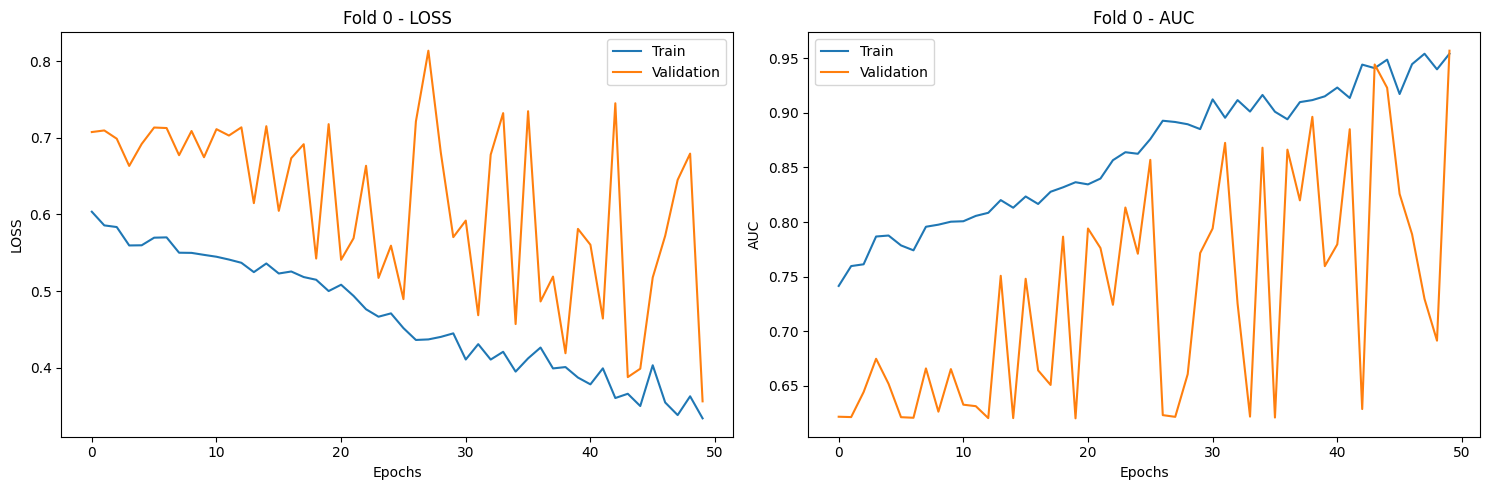

In [ ]:
# Display fold number at training start
print(f"Starting training for Fold {fold}...")

# Split the data for the current fold
train_idx, val_idx = folds[fold]
x_train_table, x_val_table = x_train_val_table[train_idx], x_train_val_table[val_idx]
x_train_image, x_val_image = x_train_val_image[train_idx], x_train_val_image[val_idx]
y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

batch_size=2

# Create TensorFlow datasets
train_dataset = create_dataset(x_train_table, x_train_image, y_train, batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = create_dataset(x_val_table, x_val_image, y_val, batch_size).prefetch(tf.data.AUTOTUNE)

# Clear the default graph and reset the session to free memory
tf.keras.backend.clear_session()

# Initialize the model
tf.random.set_seed(42)
model = multimodal_model(tabular_model, image_model, fold)

# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    metrics=[tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall")]
)

# Define callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_folder, f'fold_{fold}_{{epoch:03d}}.keras'),
    save_best_only=False
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    steps_per_epoch=len(y_train) // batch_size,
    validation_steps=len(y_val) // batch_size,
    callbacks=[checkpoint_cb],
    verbose=1
)

# Find the best epoch (based on validation AUC)
best_epoch = np.argmax(history.history['val_auc']) + 1
best_auc = np.max(history.history['val_auc'])
best_model_path = os.path.join(checkpoint_folder, f'fold_{fold}_{best_epoch:03d}.keras')

# Save the best model path
if os.path.exists(os.path.join(checkpoint_folder, "best_models.pkl")):
    # Load existing list
    with open(os.path.join(checkpoint_folder, "best_models.pkl"), "rb") as f:
        best_models = pickle.load(f)
else:
    best_models = []

best_models.append(best_model_path)

# Save the updated list
with open(os.path.join(checkpoint_folder, "best_models.pkl"), "wb") as f:
    pickle.dump(best_models, f)

# Print results
print(f"Best validation AUC for fold {fold}: {best_auc:.4f} at epoch {best_epoch}")
print(f"Best model for fold {fold} saved at: {best_model_path}")

# Plot the training history for this fold
plot_fold_history(history, fold)

## Training: fold 1

Starting training for Fold 1...
Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 40s 114ms/step - auc: 0.6481 - loss: 0.6788 - recall: 0.3306 - val_auc: 0.6856 - val_loss: 0.6773 - val_recall: 0.2985
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - auc: 0.7410 - loss: 0.6406 - recall: 0.3871 - val_auc: 0.7612 - val_loss: 0.6447 - val_recall: 0.3284
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 30s 111ms/step - auc: 0.7772 - loss: 0.6305 - recall: 0.3559 - val_auc: 0.4944 - val_loss: 0.7483 - val_recall: 0.0746
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - auc: 0.8276 - loss: 0.5870 - recall: 0.4516 - val_auc: 0.8152 - val_loss: 0.5749 - val_recall: 0.4627
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - auc: 0.8434 - loss: 0.5559 - recall: 0.8198 - val_auc: 0.8615 - val_loss: 0.5530 - val_recall: 0.7164
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - auc: 0.8764 - loss: 0.5429 - recall: 0.8649 - val_auc: 0.9750 - val_loss: 0.5022 - val_recall: 0.9254
Epoch 7/50
274

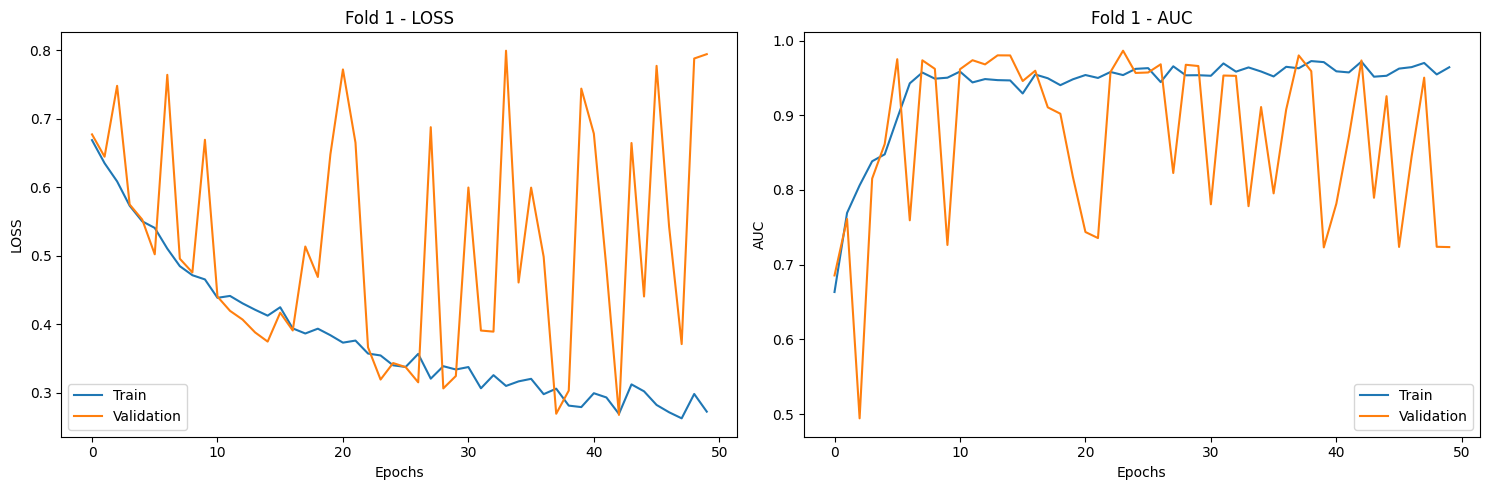

In [ ]:
fold = 1

# Display fold number at training start
print(f"Starting training for Fold {fold}...")

# Split the data for the current fold
train_idx, val_idx = folds[fold]
x_train_table, x_val_table = x_train_val_table[train_idx], x_train_val_table[val_idx]
x_train_image, x_val_image = x_train_val_image[train_idx], x_train_val_image[val_idx]
y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

batch_size=2

# Create TensorFlow datasets
train_dataset = create_dataset(x_train_table, x_train_image, y_train, batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = create_dataset(x_val_table, x_val_image, y_val, batch_size).prefetch(tf.data.AUTOTUNE)

# Clear the default graph and reset the session to free memory
tf.keras.backend.clear_session()

# Initialize the model
tf.random.set_seed(42)
model = multimodal_model(tabular_model, image_model, fold)

# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    metrics=[tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall")]
)

# Define callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_folder, f'fold_{fold}_{{epoch:03d}}.keras'),
    save_best_only=False
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    steps_per_epoch=len(y_train) // batch_size,
    validation_steps=len(y_val) // batch_size,
    callbacks=[checkpoint_cb],
    verbose=1
)

# Find the best epoch (based on validation AUC)
best_epoch = np.argmax(history.history['val_auc']) + 1
best_auc = np.max(history.history['val_auc'])
best_model_path = os.path.join(checkpoint_folder, f'fold_{fold}_{best_epoch:03d}.keras')

# Save the best model path
if os.path.exists(os.path.join(checkpoint_folder, "best_models.pkl")):
    # Load existing list
    with open(os.path.join(checkpoint_folder, "best_models.pkl"), "rb") as f:
        best_models = pickle.load(f)
else:
    best_models = []

best_models.append(best_model_path)

# Save the updated list
with open(os.path.join(checkpoint_folder, "best_models.pkl"), "wb") as f:
    pickle.dump(best_models, f)

# Print results
print(f"Best validation AUC for fold {fold}: {best_auc:.4f} at epoch {best_epoch}")
print(f"Best model for fold {fold} saved at: {best_model_path}")

# Plot the training history for this fold
plot_fold_history(history, fold)

## Training: fold 2

Starting training for Fold 2...
Epoch 1/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 39s 115ms/step - auc: 0.7201 - loss: 0.6165 - recall: 0.6741 - val_auc: 0.7295 - val_loss: 0.6459 - val_recall: 0.7288
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - auc: 0.7277 - loss: 0.6120 - recall: 0.6697 - val_auc: 0.7309 - val_loss: 0.6425 - val_recall: 0.7119
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - auc: 0.7291 - loss: 0.6107 - recall: 0.6484 - val_auc: 0.7381 - val_loss: 0.6395 - val_recall: 0.7119
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 111ms/step - auc: 0.7284 - loss: 0.6096 - recall: 0.6168 - val_auc: 0.7377 - val_loss: 0.6368 - val_recall: 0.7119
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - auc: 0.7303 - loss: 0.6087 - recall: 0.6168 - val_auc: 0.7363 - val_loss: 0.6345 - val_recall: 0.7119
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - auc: 0.7274 - loss: 0.6079 - recall: 0.6168 - val_auc: 0.7367 - val_loss: 0.6324 - val_recall: 0.7119
Epoch 7/50
275

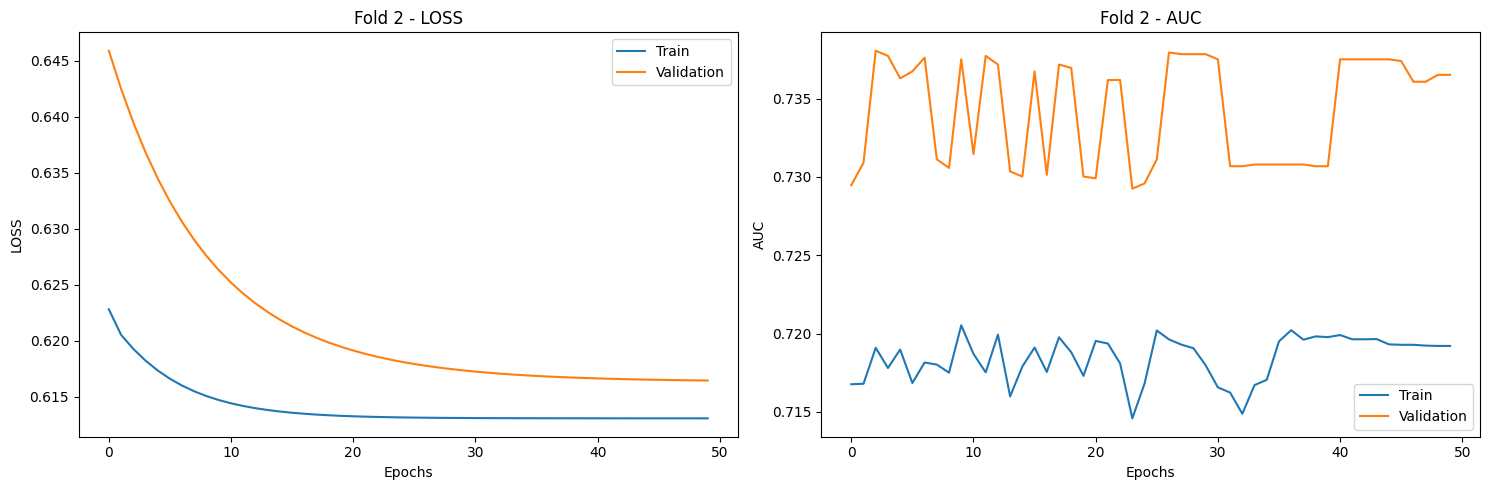

In [ ]:
fold = 2

# Display fold number at training start
print(f"Starting training for Fold {fold}...")

# Split the data for the current fold
train_idx, val_idx = folds[fold]
x_train_table, x_val_table = x_train_val_table[train_idx], x_train_val_table[val_idx]
x_train_image, x_val_image = x_train_val_image[train_idx], x_train_val_image[val_idx]
y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

batch_size=2

# Create TensorFlow datasets
train_dataset = create_dataset(x_train_table, x_train_image, y_train, batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = create_dataset(x_val_table, x_val_image, y_val, batch_size).prefetch(tf.data.AUTOTUNE)

# Clear the default graph and reset the session to free memory
tf.keras.backend.clear_session()

# Initialize the model
tf.random.set_seed(42)
model = multimodal_model(tabular_model, image_model, fold)

# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    metrics=[tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall")]
)

# Define callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_folder, f'fold_{fold}_{{epoch:03d}}.keras'),
    save_best_only=False
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    steps_per_epoch=len(y_train) // batch_size,
    validation_steps=len(y_val) // batch_size,
    callbacks=[checkpoint_cb],
    verbose=1
)

# Find the best epoch (based on validation AUC)
best_epoch = np.argmax(history.history['val_auc']) + 1
best_auc = np.max(history.history['val_auc'])
best_model_path = os.path.join(checkpoint_folder, f'fold_{fold}_{best_epoch:03d}.keras')

# Save the best model path
if os.path.exists(os.path.join(checkpoint_folder, "best_models.pkl")):
    # Load existing list
    with open(os.path.join(checkpoint_folder, "best_models.pkl"), "rb") as f:
        best_models = pickle.load(f)
else:
    best_models = []

best_models.append(best_model_path)

# Save the updated list
with open(os.path.join(checkpoint_folder, "best_models.pkl"), "wb") as f:
    pickle.dump(best_models, f)

# Print results
print(f"Best validation AUC for fold {fold}: {best_auc:.4f} at epoch {best_epoch}")
print(f"Best model for fold {fold} saved at: {best_model_path}")

# Plot the training history for this fold
plot_fold_history(history, fold)

## Training: fold 3

Starting training for Fold 3...
Epoch 1/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 39s 114ms/step - auc: 0.2717 - loss: 1.1344 - recall: 0.3074 - val_auc: 0.2190 - val_loss: 1.1422 - val_recall: 0.2698
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - auc: 0.2776 - loss: 1.0887 - recall: 0.3074 - val_auc: 0.2194 - val_loss: 1.0950 - val_recall: 0.2698
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - auc: 0.2752 - loss: 1.0450 - recall: 0.3074 - val_auc: 0.2175 - val_loss: 1.0502 - val_recall: 0.2698
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - auc: 0.2752 - loss: 1.0037 - recall: 0.3136 - val_auc: 0.2200 - val_loss: 1.0081 - val_recall: 0.2698
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - auc: 0.2746 - loss: 0.9651 - recall: 0.3318 - val_auc: 0.2172 - val_loss: 0.9687 - val_recall: 0.2698
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - auc: 0.2755 - loss: 0.9293 - recall: 0.3325 - val_auc: 0.2170 - val_loss: 0.9320 - val_recall: 0.3016
Epoch 7/50
275

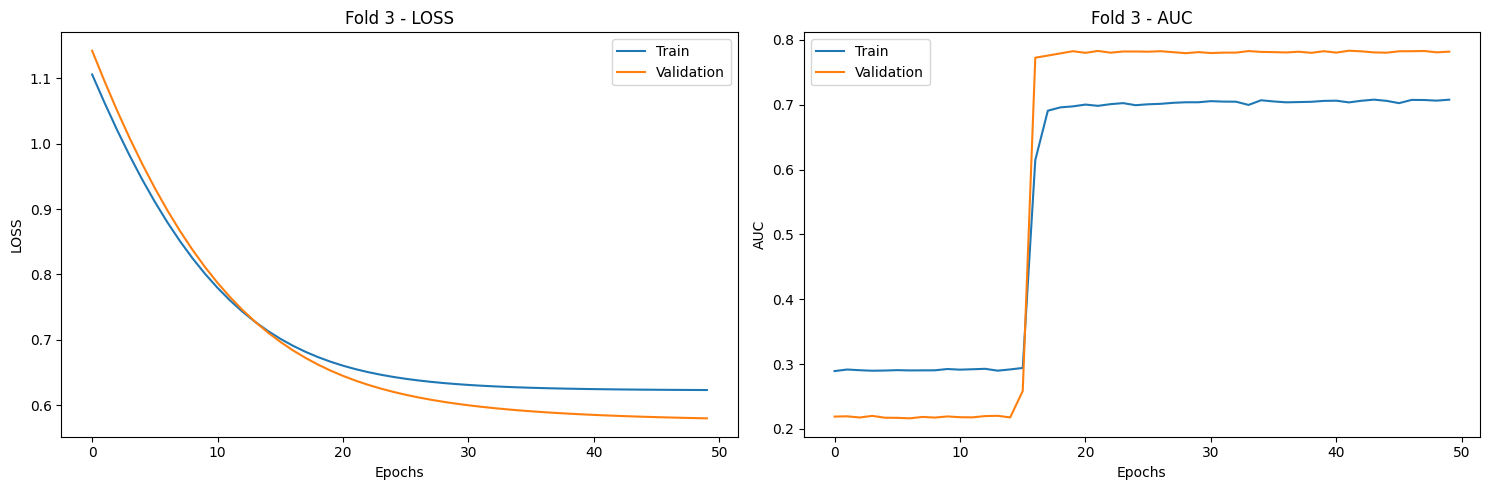

In [ ]:
fold = 3

# Display fold number at training start
print(f"Starting training for Fold {fold}...")

# Split the data for the current fold
train_idx, val_idx = folds[fold]
x_train_table, x_val_table = x_train_val_table[train_idx], x_train_val_table[val_idx]
x_train_image, x_val_image = x_train_val_image[train_idx], x_train_val_image[val_idx]
y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

batch_size=2

# Create TensorFlow datasets
train_dataset = create_dataset(x_train_table, x_train_image, y_train, batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = create_dataset(x_val_table, x_val_image, y_val, batch_size).prefetch(tf.data.AUTOTUNE)

# Clear the default graph and reset the session to free memory
tf.keras.backend.clear_session()

# Initialize the model
tf.random.set_seed(42)
model = multimodal_model(tabular_model, image_model, fold)

# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    metrics=[tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall")]
)

# Define callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_folder, f'fold_{fold}_{{epoch:03d}}.keras'),
    save_best_only=False
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    steps_per_epoch=len(y_train) // batch_size,
    validation_steps=len(y_val) // batch_size,
    callbacks=[checkpoint_cb],
    verbose=1
)

# Find the best epoch (based on validation AUC)
best_epoch = np.argmax(history.history['val_auc']) + 1
best_auc = np.max(history.history['val_auc'])
best_model_path = os.path.join(checkpoint_folder, f'fold_{fold}_{best_epoch:03d}.keras')

# Save the best model path
if os.path.exists(os.path.join(checkpoint_folder, "best_models.pkl")):
    # Load existing list
    with open(os.path.join(checkpoint_folder, "best_models.pkl"), "rb") as f:
        best_models = pickle.load(f)
else:
    best_models = []

best_models.append(best_model_path)

# Save the updated list
with open(os.path.join(checkpoint_folder, "best_models.pkl"), "wb") as f:
    pickle.dump(best_models, f)

# Print results
print(f"Best validation AUC for fold {fold}: {best_auc:.4f} at epoch {best_epoch}")
print(f"Best model for fold {fold} saved at: {best_model_path}")

# Plot the training history for this fold
plot_fold_history(history, fold)

## Training: fold 4

Starting training for Fold 4...
Epoch 1/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 72s 119ms/step - auc: 0.7304 - loss: 0.6040 - recall: 0.5898 - val_auc: 0.7634 - val_loss: 0.6078 - val_recall: 0.6462
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - auc: 0.7622 - loss: 0.5801 - recall: 0.5896 - val_auc: 0.7563 - val_loss: 0.5828 - val_recall: 0.5846
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - auc: 0.7849 - loss: 0.5657 - recall: 0.5642 - val_auc: 0.7803 - val_loss: 0.5782 - val_recall: 0.6615
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - auc: 0.7744 - loss: 0.5753 - recall: 0.5995 - val_auc: 0.7678 - val_loss: 0.5734 - val_recall: 0.5846
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - auc: 0.7897 - loss: 0.5621 - recall: 0.5857 - val_auc: 0.7873 - val_loss: 0.5712 - val_recall: 0.6769
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - auc: 0.8016 - loss: 0.5451 - recall: 0.6465 - val_auc: 0.7690 - val_loss: 0.5715 - val_recall: 0.6462
Epoch 7/50
275

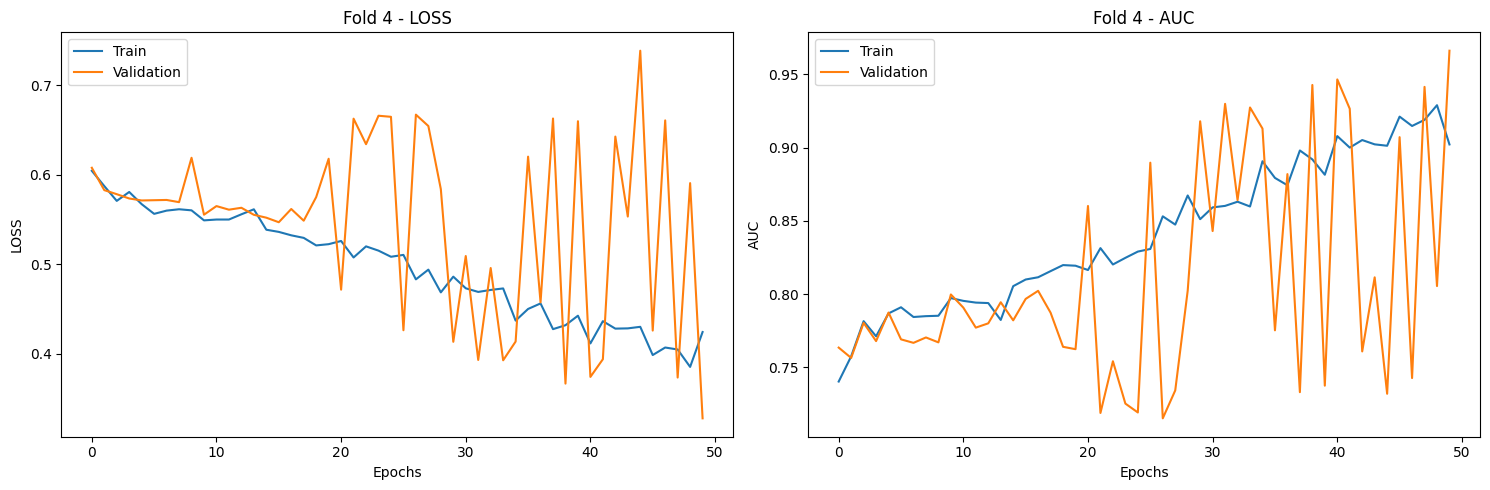

In [ ]:
fold = 4

# Display fold number at training start
print(f"Starting training for Fold {fold}...")

# Split the data for the current fold
train_idx, val_idx = folds[fold]
x_train_table, x_val_table = x_train_val_table[train_idx], x_train_val_table[val_idx]
x_train_image, x_val_image = x_train_val_image[train_idx], x_train_val_image[val_idx]
y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

batch_size=2

# Create TensorFlow datasets
train_dataset = create_dataset(x_train_table, x_train_image, y_train, batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = create_dataset(x_val_table, x_val_image, y_val, batch_size).prefetch(tf.data.AUTOTUNE)

# Clear the default graph and reset the session to free memory
tf.keras.backend.clear_session()

# Initialize the model
tf.random.set_seed(42)
model = multimodal_model(tabular_model, image_model, fold)

# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    metrics=[tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Recall(name="recall")]
)

# Define callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_folder, f'fold_{fold}_{{epoch:03d}}.keras'),
    save_best_only=False
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    steps_per_epoch=len(y_train) // batch_size,
    validation_steps=len(y_val) // batch_size,
    callbacks=[checkpoint_cb],
    verbose=1
)

# Find the best epoch (based on validation AUC)
best_epoch = np.argmax(history.history['val_auc']) + 1
best_auc = np.max(history.history['val_auc'])
best_model_path = os.path.join(checkpoint_folder, f'fold_{fold}_{best_epoch:03d}.keras')

# Save the best model path
if os.path.exists(os.path.join(checkpoint_folder, "best_models.pkl")):
    # Load existing list
    with open(os.path.join(checkpoint_folder, "best_models.pkl"), "rb") as f:
        best_models = pickle.load(f)
else:
    best_models = []

best_models.append(best_model_path)

# Save the updated list
with open(os.path.join(checkpoint_folder, "best_models.pkl"), "wb") as f:
    pickle.dump(best_models, f)

# Print results
print(f"Best validation AUC for fold {fold}: {best_auc:.4f} at epoch {best_epoch}")
print(f"Best model for fold {fold} saved at: {best_model_path}")

# Plot the training history for this fold
plot_fold_history(history, fold)

## Ensemble Prediction with training and validation data without data augmentation (rawTrainVal set) for optimal threshold determination

In [ ]:
train_val_predictions = []  # Store predictions from all folds for rawTrainVal set

print("rawTrainVal Metrics for Each Fold:")
for fold, model_path in enumerate(best_models):
    print(f"\nFold {fold} rawTrainVal Metrics:")

    # Load the best model for this fold
    model = tf.keras.models.load_model(model_path)

    # Predict on the rawTrainVal dataset
    y_pred = model.predict(
        [x_train_val_table_raw, x_train_val_image_raw],  # Input includes both table and image raw data
        batch_size=2
    )
    y_pred_binary = (y_pred >= 0.5).astype(int)  # Convert probabilities to binary predictions

    # Compute confusion matrix
    cm = confusion_matrix(y_train_val_raw.squeeze(), y_pred_binary)
    tn, fp, fn, tp = cm.ravel()

    # Compute metrics
    auc_value = roc_auc_score(y_train_val_raw.squeeze(), y_pred)
    recall = recall_score(y_train_val_raw.squeeze(), y_pred_binary)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # Handle division by zero

    # Print results for the fold
    print(f"Confusion Matrix:\n{cm}")
    print(f"AUC: {auc_value:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")

    # Store fold predictions
    train_val_predictions.append(y_pred.squeeze())

# Ensemble predictions (average predictions across all folds for rawTrainVal dataset)
averaged_train_val_predictions = np.mean(train_val_predictions, axis=0)

# ------------------------- Compute Optimal Threshold -------------------------
# Compute ROC curve and AUC for the Training+Validation dataset
fpr, tpr, thresholds = roc_curve(y_train_val_raw.squeeze(), averaged_train_val_predictions)
roc_auc_train_val = auc(fpr, tpr)

# Compute Specificity (1 - FPR)
specificity = 1 - fpr

# Compute Youden's J statistic
j_scores = tpr + specificity - 1

# Find the optimal threshold for Training+Validation data
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nOptimal Threshold from Training+Validation Data: {optimal_threshold:.4f}")
print(f"AUC (Training+Validation): {roc_auc_train_val:.4f}")
print(f"Recall at Optimal Threshold: {tpr[optimal_idx]:.4f}")
print(f"Specificity at Optimal Threshold: {specificity[optimal_idx]:.4f}")

# Final evaluation on rawTrainVal dataset with Default Threshold
final_predictions_train_val = (averaged_train_val_predictions >= 0.5).astype(int)
final_cm_train_val = confusion_matrix(y_train_val_raw.squeeze(), final_predictions_train_val)
tn, fp, fn, tp = final_cm_train_val.ravel()
final_auc_train_val = roc_auc_score(y_train_val_raw.squeeze(), averaged_train_val_predictions)
final_recall_train_val = tp / (tp + fn)
final_specificity_train_val = tn / (tn + fp)

print("\nFinal Ensemble rawTrainVal Metrics (Default Threshold 0.5):")
print(f"Confusion Matrix:\n{final_cm_train_val}")
print(f"AUC: {final_auc_train_val:.4f}")
print(f"Recall: {final_recall_train_val:.4f}")
print(f"Specificity: {final_specificity_train_val:.4f}")

# Final evaluation on rawTrainVal dataset with Optimal Threshold
final_predictions_train_val_optimal = (averaged_train_val_predictions >= optimal_threshold).astype(int)
final_cm_train_val_optimal = confusion_matrix(y_train_val_raw.squeeze(), final_predictions_train_val_optimal)
tn_optimal, fp_optimal, fn_optimal, tp_optimal = final_cm_train_val_optimal.ravel()
final_recall_train_val_optimal = tp_optimal / (tp_optimal + fn_optimal)
final_specificity_train_val_optimal = tn_optimal / (tn_optimal + fp_optimal)

print("\nFinal Ensemble rawTrainVal Metrics (Optimal Threshold):")
print(f"Confusion Matrix:\n{final_cm_train_val_optimal}")
print(f"Recall: {final_recall_train_val_optimal:.4f}")
print(f"Specificity: {final_specificity_train_val_optimal:.4f}")

rawTrainVal Metrics for Each Fold:

Fold 0 rawTrainVal Metrics:
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step
Confusion Matrix:
[[338  19]
 [ 21  34]]
AUC: 0.9341
Recall: 0.6182
Specificity: 0.9468

Fold 1 rawTrainVal Metrics:
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step
Confusion Matrix:
[[322  35]
 [  2  53]]
AUC: 0.9655
Recall: 0.9636
Specificity: 0.9020

Fold 2 rawTrainVal Metrics:
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step
Confusion Matrix:
[[250 107]
 [ 20  35]]
AUC: 0.7205
Recall: 0.6364
Specificity: 0.7003

Fold 3 rawTrainVal Metrics:
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step
Confusion Matrix:
[[263  94]
 [ 21  34]]
AUC: 0.7217
Recall: 0.6182
Specificity: 0.7367

Fold 4 rawTrainVal Metrics:
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step
Confusion Matrix:
[[345  12]
 [ 33  22]]
AUC: 0.8642
Recall: 0.4000
Specificity: 0.9664

Optimal Threshold from Training+Validation Data: 0.3334
AUC (Training+Validation): 0.9022
Recall at Optimal Threshold: 1.0000
Specificity at Optimal Threshold: 0.6667

F

# **Test**

## Ensemble Prediction with test data

In [ ]:
test_predictions = []  # Store predictions from all folds for the test dataset

print("\nTest Metrics for Each Fold:")
for fold, model_path in enumerate(best_models):
    print(f"\nFold {fold} Test Metrics:")

    # Load the best model for this fold
    model = tf.keras.models.load_model(model_path)

    # Predict on the test dataset
    y_pred = model.predict(
        [x_test_table, x_test_image],  # Input includes both table and image test data
        batch_size=2
    )
    y_pred_binary = (y_pred >= 0.5).astype(int)  # Convert probabilities to binary predictions

    # Compute confusion matrix
    cm = confusion_matrix(y_test.squeeze(), y_pred_binary)
    tn, fp, fn, tp = cm.ravel()

    # Compute metrics
    auc_value = roc_auc_score(y_test.squeeze(), y_pred)
    recall = recall_score(y_test.squeeze(), y_pred_binary)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # Handle division by zero

    # Print results for the fold
    print(f"Confusion Matrix:\n{cm}")
    print(f"AUC: {auc_value:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")

    # Store fold predictions
    test_predictions.append(y_pred.squeeze())

# Ensemble predictions (average predictions across all folds for the test dataset)
averaged_test_predictions = np.mean(test_predictions, axis=0)

# ------------------------- Final Evaluation on Test Dataset -------------------------
# Default Threshold (0.5)
final_predictions_test = (averaged_test_predictions >= 0.5).astype(int)
final_cm_test = confusion_matrix(y_test.squeeze(), final_predictions_test)
tn, fp, fn, tp = final_cm_test.ravel()
final_auc_test = roc_auc_score(y_test.squeeze(), averaged_test_predictions)
final_recall_test = tp / (tp + fn)
final_specificity_test = tn / (tn + fp)

print("\nFinal Ensemble Test Metrics (Default Threshold 0.5):")
print(f"Confusion Matrix:\n{final_cm_test}")
print(f"AUC: {final_auc_test:.4f}")
print(f"Recall: {final_recall_test:.4f}")
print(f"Specificity: {final_specificity_test:.4f}")

# Optimal Threshold
final_predictions_test_optimal = (averaged_test_predictions >= optimal_threshold).astype(int)
final_cm_test_optimal = confusion_matrix(y_test.squeeze(), final_predictions_test_optimal)
tn_optimal_test, fp_optimal_test, fn_optimal_test, tp_optimal_test = final_cm_test_optimal.ravel()
final_recall_test_optimal = tp_optimal_test / (tp_optimal_test + fn_optimal_test)
final_specificity_test_optimal = tn_optimal_test / (tn_optimal_test + fp_optimal_test)

print("\nFinal Ensemble Test Metrics (Optimal Threshold):")
print(f"Confusion Matrix:\n{final_cm_test_optimal}")
print(f"Recall: {final_recall_test_optimal:.4f}")
print(f"Specificity: {final_specificity_test_optimal:.4f}")



Test Metrics for Each Fold:

Fold 0 Test Metrics:
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
Confusion Matrix:
[[90 15]
 [20 15]]
AUC: 0.7483
Recall: 0.4286
Specificity: 0.8571

Fold 1 Test Metrics:
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
Confusion Matrix:
[[74 31]
 [11 24]]
AUC: 0.7533
Recall: 0.6857
Specificity: 0.7048

Fold 2 Test Metrics:
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
Confusion Matrix:
[[66 39]
 [10 25]]
AUC: 0.7347
Recall: 0.7143
Specificity: 0.6286

Fold 3 Test Metrics:
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
Confusion Matrix:
[[70 35]
 [10 25]]
AUC: 0.7373
Recall: 0.7143
Specificity: 0.6667

Fold 4 Test Metrics:
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
Confusion Matrix:
[[94 11]
 [20 15]]
AUC: 0.7936
Recall: 0.4286
Specificity: 0.8952

Final Ensemble Test Metrics (Default Threshold 0.5):
Confusion Matrix:
[[73 32]
 [ 6 29]]
AUC: 0.7986
Recall: 0.8286
Specificity: 0.6952

Final Ensemble Test Metrics (Optimal Threshold):
Confusion Matrix:
[[56 49]
 [ 4 31]]
Recall: 0.8857
S